In [1]:
from src.utils import *
from src.plots import *

In [2]:
p = r'/Users/jquinnlee/Desktop/georepca1/georepca1'
os.chdir(p)

In [3]:
animals = ['QLAK-CA1-08', 'QLAK-CA1-30', 'QLAK-CA1-50', 'QLAK-CA1-51', 'QLAK-CA1-56', 'QLAK-CA1-74', 'QLAK-CA1-75']

##
##### Optionally convert original matlab files to joblib files (large) that can be loaded efficiently in Python

In [4]:
# for animal in tqdm(animals):
#     mat2joblib(animal, p)

In [5]:
animal = animals[2]
dat = load_dat(animal, p, format="joblib")

Loading preprocessed data for animal QLAK-CA1-50


## Figure 1C
### Plot example event rate maps from CA1 neurons across sessions in a geometric sequence


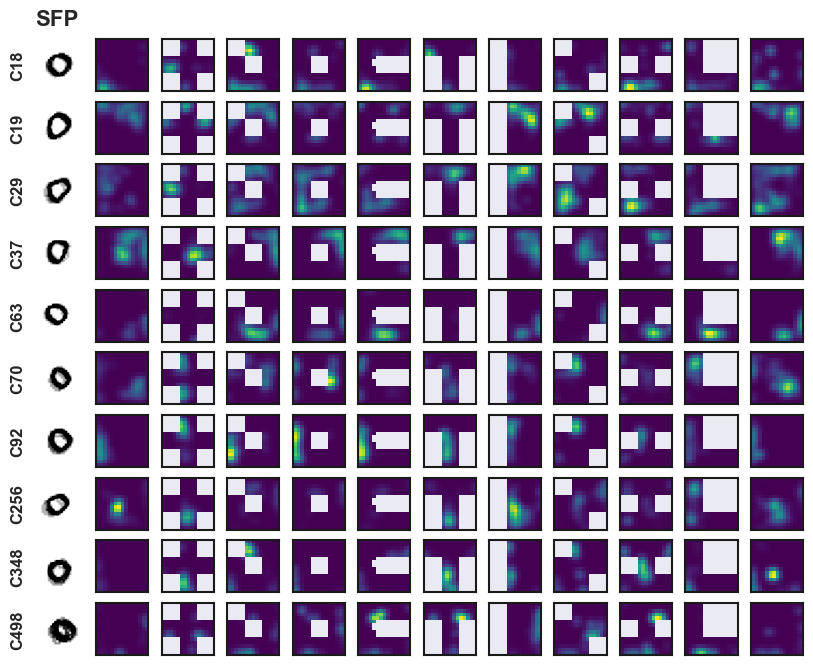

In [9]:
# Use example cells and sessions from paper
example_cells_idx = np.array([17, 18, 28, 36, 62, 69, 91, 255, 347, 497])
example_days_idx = np.arange(20, 31)
# Index example maps and create contours from spatial footprints ("SFPs")
example_maps = {"smoothed": dat[animal]["maps"]["smoothed"][:, :, example_cells_idx, :][:, :, :, example_days_idx]}
example_sfps = trace_sfps(dat[animal]['SFPs'])[:, :, example_cells_idx, :][:, :, :, example_days_idx]
plot_maps(example_maps, animal,  p, example_sfps, example_cells_idx, unsmoothed=False, cmap='viridis')


##
## Figure 1E-F Split half spatial reliability and Bayesian position decoding accuracy

In [7]:

def get_all_decoding_within(animals, down_sample=False, shuffle=False, p=r'I:\weirdGeos\AggPreloads'):
    os.chdir(p)
    if down_sample:
        group_decoding = joblib.load('within_decoding_ds')
    elif shuffle and not down_sample:
        group_decoding = joblib.load('within_decoding_shuffle')
    else:
        group_decoding = joblib.load('within_decoding')
    n_animals = len(list(group_decoding.keys()))
    max_days = max([group_decoding[animal]['decoding_error'].shape[0] for animal in list(group_decoding.keys())])
    decoding = np.zeros([n_animals, int(max_days)]) * np.nan
    for a, animal in enumerate(list(group_decoding.keys())):
        n_days = group_decoding[animal]['decoding_error'].shape[0]
        decoding[a, :n_days] = group_decoding[animal]['decoding_error'].mean(1)
    cols = ['Day', 'Animal', 'Decoding Error']
    df_decoding = pd.DataFrame(columns=cols, data=np.zeros([decoding.ravel().shape[0], len(cols)])*np.nan)
    idx = 0
    for a in range(decoding.shape[0]):
        for d in range(decoding.shape[1]):
            df_decoding.iloc[idx] = pd.Series(np.array([d, a, decoding[a, d]]))
            idx += 1
    return df_decoding.dropna(axis=0)

In [8]:


def plot_SHR_pvals(df_pvals, alpha=[0.05, 0.01, 0.001]):
    sns.set(style='dark', font_scale=1.75)
    
    if len(alpha) == 3:
        plt.figure(figsize=(4, 5))
        df_pvals_a, df_pvals_b, df_pvals_c = deepcopy(df_pvals), deepcopy(df_pvals), deepcopy(df_pvals)
        ax = plt.subplot()
        df_pvals_a['SHR'] = df_pvals_a['SHR'] < alpha[0]
        sns.lineplot(data=df_pvals_a.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', units='Animal', linewidth=1,
                     estimator=None, alpha=.25, c='b')
        sns.lineplot(data=df_pvals_a.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', linewidth=4,
                     estimator='mean',
                     errorbar='se', c='b')

        df_pvals_b['SHR'] = df_pvals_b['SHR'] < alpha[1]
        sns.lineplot(data=df_pvals_b.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', units='Animal',
                     linewidth=1,
                     estimator=None, alpha=.25, c='orchid')
        sns.lineplot(data=df_pvals_b.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', linewidth=4,
                     estimator='mean',
                     errorbar='se', c='orchid')

        df_pvals_c['SHR'] = df_pvals_c['SHR'] < alpha[2]
        sns.lineplot(data=df_pvals_c.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', units='Animal',
                     linewidth=1,
                     estimator=None, alpha=.25, c="coral")
        sns.lineplot(data=df_pvals_c.groupby(by=['Animal', 'Day']).mean(), x='Day', y='SHR', linewidth=4,
                     estimator='mean',
                     errorbar='se', c="coral")

        ax.set_xticks(np.arange(0, df_pvals['Day'].max() + 1, 10).astype(int))
        ax.set_xticklabels(np.arange(1, df_pvals['Day'].max() + 2, 10).astype(int))
        ax.set_ylim([0, 1.])
        ax.set_yticks(np.linspace(0, 1., 6))
        ax.set_ylabel(f'Proportion place cells', weight='bold')
        ax.text(x=0, y=1.1, s="p < 0.05", c="b", size=18, weight="bold")
        ax.text(x=12, y=1.1, s="< 0.01", c="orchid", size=18, weight="bold")
        ax.text(x=21, y=1.1, s="< 0.001", c="coral", size=18, weight="bold")
        ax.set_xlabel('Day', weight='bold')
        plt.show()
    
        
def plot_decoding_within_days(df_decoding, shuffle=False, residual=False, vmax=40, plot_min_line=True):
    sns.set(style='dark', font_scale=1.75)
    plt.figure(figsize=(4, 5))
    ax = plt.subplot()
    if plot_min_line:
        ax.axhline(10, linewidth=3, linestyle="--", c="gray") # set line for theoretical max
    sns.lineplot(data=df_decoding, x='Day', y='Error', units='Animal', linewidth=1, estimator=None, alpha=.25)
    sns.lineplot(data=df_decoding, x='Day', y='Error', linewidth=4, estimator='mean', color='b')
    ax.set_xticks(np.arange(0, df_decoding['Day'].max() + 1, 10).astype(int))
    ax.set_xticklabels(np.arange(1, df_decoding['Day'].max() + 2, 10).astype(int))
    if residual:
        ax.set_ylim([-10, vmax - 10])
        ax.set_yticks(np.linspace(-10, vmax, 6))
        ax.axhline(0, linewidth=3, linestyle="--", c="gray")
    else:
        ax.set_ylim([0, vmax])
        ax.set_yticks(np.linspace(0, vmax, 6))
    ax.set_ylabel('Mean Decoding Error (cm)', weight='bold')
    ax.set_xlabel('Day', weight='bold')
    plt.show()

One-way ANOVA for SHR across days: 
               df       sum_sq   mean_sq          F         PR(>F)
C(Day)       30.0    38.044337  1.268145  37.400643  5.713181e-215
Residual  69713.0  2363.760478  0.033907        NaN            NaN
One-way ANOVA for decoding error across days: 
             df       sum_sq    mean_sq         F        PR(>F)
C(Day)     30.0  2492.688986  83.089633  7.984461  4.419410e-20
Residual  176.0  1831.529461  10.406417       NaN           NaN


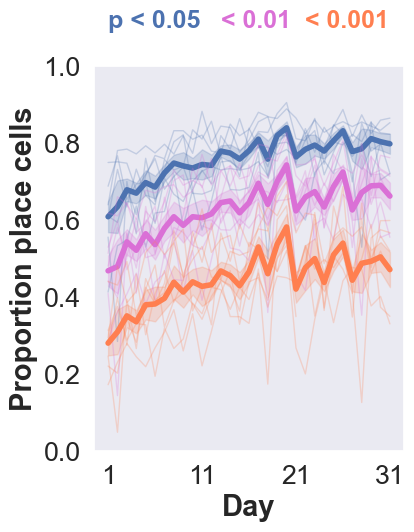

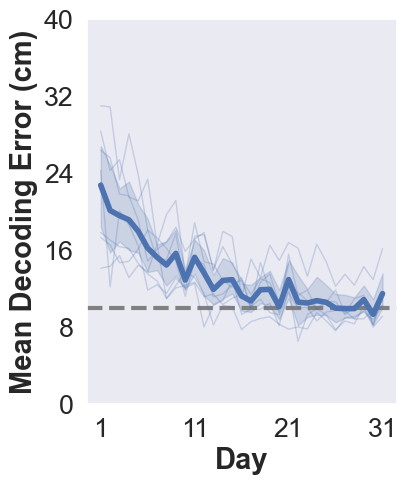

In [9]:
# Load split-half reliability p values from all animals and all sessions into single dataframe
df_pvals = joblib.load(os.path.join(p, "results", "df_shr_pvals"))
# STATS One-way ANOVA
formula = 'SHR ~ C(Day)'
lm = ols(formula, df_pvals).fit()
print(f"One-way ANOVA for SHR across days: \n{anova_lm(lm)}")
df_decoding = get_all_decoding_within(animals, p=os.path.join(p, "results"))
# STATS One-way ANOVA
df_decoding.columns = ["Day", "Animal", "Error"] # revise column names so it works for statsmodels
formula = 'Error ~ C(Day)'
lm = ols(formula, df_decoding).fit()
print(f"One-way ANOVA for decoding error across days: \n{anova_lm(lm)}")
# Plot SHR and decoding error across all recordings
plot_SHR_pvals(df_pvals)
plot_decoding_within_days(df_decoding)


##
## Figure 1H-I - Rate map (entire map) representational similarity and nMDS embedding

In [143]:

def get_environment_label(env_name, flipud=False):
    '''
    get_environment label will return a custom maker from environment name as input that can be used for plotting
    '''
    codes = False
    # First draw vertices that will create the shape of the environment based on input name (env names in weirdGeos dat)
    if env_name == 'square':
        polys = np.array([[0, 0], [0, 30], [30, 30], [30, 0], [0, 0]])-15
    elif env_name == 'o':
        polys_outside = np.array([[0, 0], [0, 30], [30, 30], [30, 0], [0, 0]]) - 15
        polys_inside = np.array([[10, 10], [10, 21], [21, 21], [21, 10], [10, 10]]) - 15
        polys = np.concatenate((polys_outside[::1], polys_inside[::-1]))
        codes = np.ones(polys.shape[0], dtype=mpath.Path.code_type) * mpath.Path.LINETO
        codes[0] = mpath.Path.MOVETO
        codes[5] = mpath.Path.MOVETO
    elif env_name == 't':
        polys = np.array([[10, 0], [10, 21], [0, 21], [0, 30], [30, 30], [30, 21], [21, 21], [21, 0], [10, 0]]) - 15
    elif env_name == 'u':
        if flipud:
            polys = np.array([[0, 0], [0, 10], [21, 10], [21, 21], [0, 21], [0, 30], [30, 30], [30, 0], [0, 0]]) - 15
        else:
            polys = np.array([[0, 0], [30, 0], [30, 10], [10, 10], [10, 21], [30, 21], [30, 30], [0, 30], [0, 0]]) - 15
    elif env_name == 'rectangle':
        polys = np.array([[10, 0], [30, 0], [30, 30], [10, 30], [10, 0]]) - 15
    elif env_name == '+':
        polys = np.array([[0, 10], [10, 10], [10, 0], [21, 0], [21, 10], [30, 10], [30, 21], [21, 21], [21, 30],
                          [10, 30], [10, 21], [0, 21], [0, 10]]) - 15
    elif env_name == 'i':
        polys = np.array([[0, 0], [30, 0], [30, 10], [21, 10], [21, 21], [30, 21], [30, 30], [0, 30], [0, 21],
                          [10, 21], [10, 10], [0, 10], [0, 0]]) - 15
    elif env_name == 'l':
        if flipud:
            polys = np.array([[0, 0], [0, 10], [21, 10], [21, 30], [30, 30], [30, 0], [0, 0]]) - 15
        else:
            polys = np.array([[0, 0], [0, 30], [10, 30], [10, 10], [30, 10], [30, 0], [0, 0]]) - 15
    elif env_name == 'bit donut':
        if flipud:
            polys = np.array([[0, 0], [30, 0], [30, 21], [21, 21], [21, 10], [10, 10], [10, 21], [21, 21], [21, 30],
                              [0, 30], [0, 0]]) - 15
        else:
            polys = np.array([[0, 0], [30, 0], [30, 30], [10, 30], [10, 21], [21, 21], [21, 10], [10, 10], [10, 21],
                                  [0, 21], [0, 0]]) - 15
    elif env_name == 'glenn':
        if flipud:
            polys = np.array([[0,  0], [0, 21], [9, 21], [9, 30], [30, 30], [30, 9], [21, 9], [21, 0], [0, 0]]) - 15
        else:
            polys = np.array([[10, 0], [30, 0], [30, 21], [21, 21], [21, 30], [0, 30], [0, 10], [10, 10], [10, 0]]) - 15
    # Use Path function to create image path that matplotlib can plot
    if np.any(codes):
        if flipud:
            return mpath.Path(np.fliplr(polys), codes), -1 * polys
        else:
            return mpath.Path(np.fliplr(polys), codes), polys
    else:
        if flipud:
            return mpath.Path(np.fliplr(polys)), -1 * polys
        else:
            return mpath.Path(np.fliplr(polys)), polys
            
    
def plot_map_corr_mds(mean_map_corr, labels, vmax=.5, cbar_title="Ratemap correlation"):

    mds_ = MDS(n_components=2, metric=False, n_jobs=9, n_init=1, max_iter=int(1e12), eps=1e-12, random_state=9003,
               dissimilarity='precomputed')
    mds_.fit(1-mean_map_corr)
    embeddings = deepcopy(mds_.embedding_)
    # for square shape take the average of the two at ends of sequence to account for drift
    embeddings[0] = np.array([embeddings[0], embeddings[-1]]).mean(0)
    embeddings -= np.mean(embeddings, axis=0)
    embeddings += np.array([.15, -.15])
    e_polys = [get_environment_label(env)[1] for env in labels[:-1]]
    sns.set(style="dark", font_scale=2.)
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    # add custom, colored patches of shapes within plot for legend
    label_scale = np.array([0.005, 0.005])
    cmap = mpl.cm.get_cmap('cool')
    for i, poly in enumerate(e_polys):
        ax.add_patch(patches.PathPatch(mpath.Path(poly * label_scale + np.array([embeddings[i, 0],
                                                                                 embeddings[i, 1]])),
                                       clip_on=False, facecolor=cmap(i/(len(labels)-1)), edgecolor=cmap(i/(len(labels)-1))))
    plt.legend([], frameon=False)
    ax.set_ylim([-.75, .75])
    ax.set_xlim([-.75, .75])
    ax.set_xticks(np.linspace(-.75, .75, 2))
    ax.set_xlabel('nMDS Dim1 ($a.u.$)', weight="bold", labelpad=-15)
    ax.set_yticks(np.linspace(-.75, .75, 2))
    ax.set_ylabel('nMDS Dim2 ($a.u.$)', weight="bold", labelpad=-45)
    plt.text(-.65, -.65, f"$stress1$={mds_.stress_:.3f}", weight="bold", fontsize=18)
    plt.tight_layout()
    plt.setp(ax.spines.values(), linewidth=4., color="k")
    plt.show()

    return fig


def plot_map_corr_rsm_ordered(mean_map_corr, labels, vmax=.5, vmin=.0, cbar_title="Ratemap correlation"):
    # plot map correlation rsm defined by hard-coded order (clustered and determined visually from dendrogram)
    temp_corr = deepcopy(mean_map_corr)
    reorder_list = np.array(["+", "rectangle", "glenn", "square", "l", "bit donut", "o", "u", "i", "t"])
    reorder_idx = np.array([np.where(labels[:-1] == label)[0] for label in reorder_list]).ravel()
    e_polys = [get_environment_label(env, flipud=True)[1] for env in labels[:-1][reorder_idx]]
    sns.set(style="dark", font_scale=2.)
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    temp_corr[np.eye(temp_corr.shape[0]).astype(bool)] = np.nan
    mappable = ax.imshow(temp_corr[:-1, :-1][reorder_idx, :][:, reorder_idx],
                         vmin=vmin, vmax=vmax, cmap="inferno", origin="upper")
    cbar = plt.colorbar(mappable, shrink=.7)
    cbar.ax.set_ylabel(cbar_title, weight="bold", labelpad=15, rotation=270)
    # cbar.ax.set_title("$R$", weight="bold")
    cbar.ax.set_yticks(np.linspace(vmin, vmax, 2))
    label_scale = np.array([0.02, 0.02])
    tickypos = -1.5
    tickxpos = 0
    cmap = mpl.cm.get_cmap('cool')
    for j, poly in enumerate(e_polys):
        ax.add_patch(patches.PathPatch(mpath.Path(poly * label_scale + np.array([tickxpos, tickypos])),
                                                   clip_on=False, facecolor="b",
                                                   edgecolor="b"))
        tickxpos += 1.
    tickypos = 0
    tickxpos = -1.5
    cmap = mpl.cm.get_cmap('cool')
    for j, poly in enumerate(e_polys):
        ax.add_patch(patches.PathPatch(mpath.Path(poly * label_scale + np.array([tickxpos, tickypos])),
                                                   clip_on=False, facecolor="b",
                                                   edgecolor="b"))
        tickypos += 1.
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(cbar.ax.spines.values(), color="k", linewidth=4.)
    plt.setp(ax.spines.values(), color="k", linewidth=4.)
    plt.tight_layout()
    plt.show()
    return fig

def plot_map_corr_dendrogram(mean_map_corr, labels):
    # make a temporary copy of the mean map correlation
    temp_corr = deepcopy(mean_map_corr)
    temp_corr[:, 0] = np.vstack((temp_corr[:, 0], np.flip(temp_corr[:, -1]))).mean(0)
    temp_corr[0, :] = temp_corr[:, 0]
    # Calculate distance matrix
    distance_matrix = 1-temp_corr[:-1, :-1]
    Z = linkage(distance_matrix, method='single')
    # plot the dedrogram of similarities
    sns.set(style="dark", font_scale=2.)
    fig = plt.figure(figsize=(7, 6))
    ax = plt.subplot()
    D = dendrogram(Z, labels=labels[:-1], ax=ax)
    e_polys = [get_environment_label(env)[1] for env in D["ivl"]]
    ax.set_ylim([0.7, 1.05])
    tickxpos = 5.
    tickypos = .68
    label_scale = np.array([0.15, 0.00075])
    cmap = mpl.cm.get_cmap('cool')
    for j, poly in enumerate(e_polys):
        ax.add_patch(patches.PathPatch(mpath.Path(poly * label_scale + np.array([tickxpos, tickypos])),
                                                   clip_on=False, facecolor="b",
                                                   edgecolor="b"))
        tickxpos += 10
    plt.xticks([])
    plt.ylabel('Distance', weight="bold")
    plt.tight_layout()
    plt.setp(ax.spines.values(), linewidth=4., color="k")
    plt.show()
    return fig


In [11]:
# calculate the average map correlation across geometries, and plot as RSM and with non-metric MDS and dendrogram
mean_map_corr, _, labels, map_corr_animals_sequences = get_mean_map_corr(animals)
map_corr_dict = {"mean_map_corr": mean_map_corr,
                 "labels": labels,
                 "map_corr_animals_sequences": map_corr_animals_sequences}
joblib.dump(map_corr_dict, os.path.join(p, "results", "map_corr_envs"))
map_corr_dict = joblib.load(os.path.join(p, "results", "map_corr_envs"))
mean_map_corr, labels, map_corr_animals_sequences = map_corr_dict["mean_map_corr"], map_corr_dict["labels"], map_corr_dict["map_corr_animals_sequences"]

Correlating ratemaps across days and cell pairs: 515it [00:35, 14.55it/s] 
Correlating ratemaps across days and cell pairs: 875it [01:11, 12.28it/s] 
Correlating ratemaps across days and cell pairs: 942it [01:05, 14.28it/s] 
Correlating ratemaps across days and cell pairs: 554it [00:16, 33.37it/s] 
Correlating ratemaps across days and cell pairs: 862it [01:02, 13.69it/s] 
Correlating ratemaps across days and cell pairs: 713it [00:48, 14.64it/s]
Correlating ratemaps across days and cell pairs: 952it [01:03, 15.11it/s]


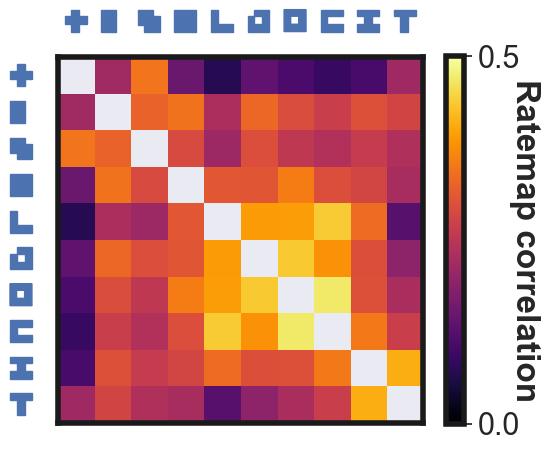

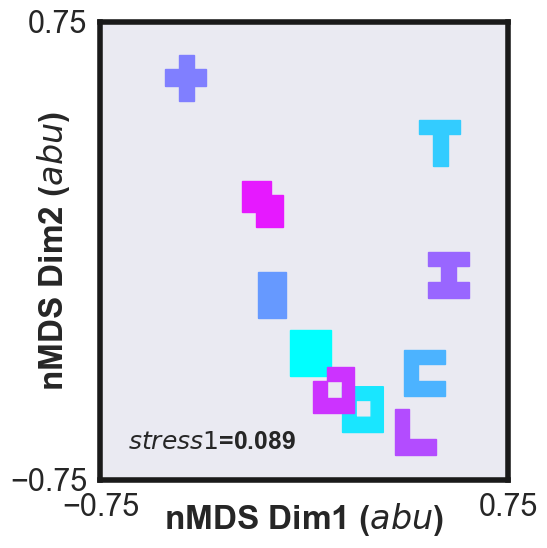

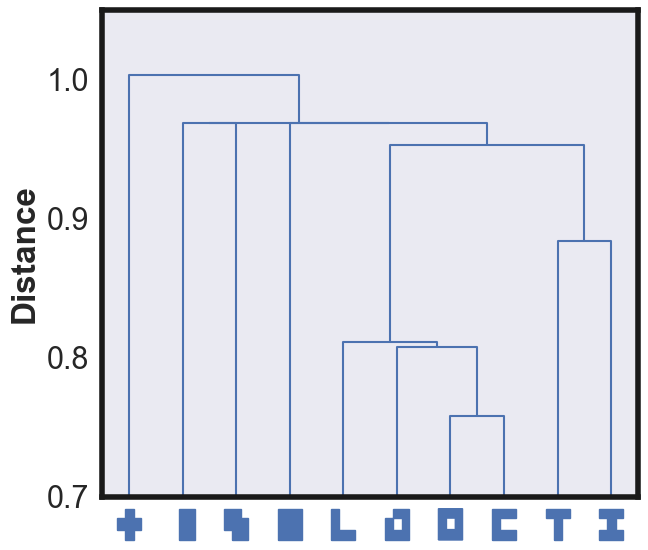

In [144]:
fig_h = plot_map_corr_rsm_ordered(mean_map_corr, labels)
fig_i = plot_map_corr_mds(mean_map_corr, labels)
fig_j = plot_map_corr_dendrogram(mean_map_corr, labels)

##
## Figure 1K - Animal-wise representational similarity

Calculating rate map correlation rsm similarity across animals: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]
Calculating rate map correlation rsm similarity across animals: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]
Calculating rate map correlation rsm similarity across animals: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


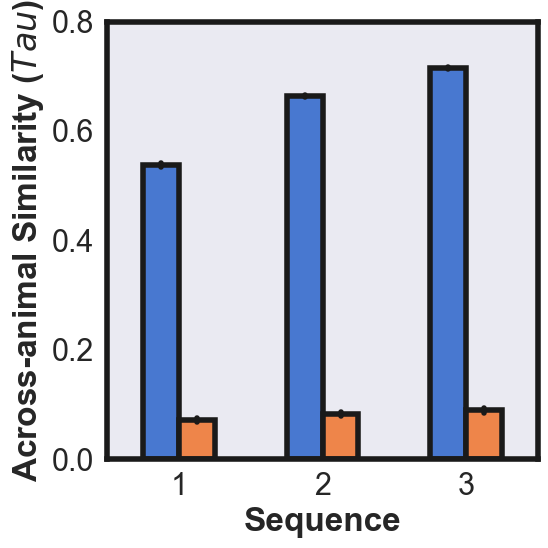

In [63]:
# how correlated are the map correlation rsms (non-partitioned) across animals and sequences?
n_sims = 100
s_prop = 0.9
np.random.seed(2023)
method = "Tau"
cols = ["Animal A", "Animal B", "Sequence", "Fit", "Shuffle"]
map_corr_animal_sequence_similarity = np.zeros([len(animals)**2 * 3 * n_sims * 2, len(cols)]) * np.nan
c = 0
for s in range(map_corr_animals_sequences.shape[1]):
    for a1 in tqdm(range(len(animals)), desc="Calculating rate map correlation rsm similarity across animals",
                   position=0, leave=True):
        for a2 in range(len(animals)):
            temp_corr1, temp_corr2 = map_corr_animals_sequences[a1, s, :, :], map_corr_animals_sequences[a2, s, :, :]
            for i in range(n_sims):
                choice_idx = np.argwhere(np.tri(temp_corr1.shape[0], k=-1))
                choice_idx = choice_idx[np.random.choice(np.arange(choice_idx.shape[0]),
                                                         size=int(choice_idx.shape[0] * s_prop),
                                                         replace=True)]
                if np.any(~np.isnan(temp_corr1)) and np.any(~np.isnan(temp_corr2)):
                    if method == "Tau":
                        actual = kendalltau(temp_corr1[choice_idx], temp_corr2[choice_idx])[0]
                        shuffle = kendalltau(np.random.permutation(temp_corr1)[choice_idx], temp_corr2[choice_idx])[0]
                    else:
                        actual = pearsonr(temp_corr1[choice_idx].ravel(), temp_corr2[choice_idx].ravel())[0]
                        shuffle = pearsonr(np.random.permutation(temp_corr1)[choice_idx].ravel(),
                                           temp_corr2[choice_idx].ravel())[0]
                    map_corr_animal_sequence_similarity[c] = np.hstack((a1, a2, s+1, actual, False))
                    c += 1
                    map_corr_animal_sequence_similarity[c] = np.hstack((a1, a2, s + 1, shuffle, True))
                    c += 1

df_map_corr_animals_sequences = pd.DataFrame(data=map_corr_animal_sequence_similarity, columns=cols)
df_map_corr_animals_sequences.dropna(axis=0, inplace=True)
df_map_corr_animals_sequences = df_map_corr_animals_sequences[df_map_corr_animals_sequences["Animal A"] !=
                                                              df_map_corr_animals_sequences["Animal B"]]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.barplot(data=df_map_corr_animals_sequences, x="Sequence", y="Fit", hue="Shuffle", legend=False,
            width=.5, edgecolor="k", linewidth=4., errcolor="k", errwidth=4., palette="muted", saturation=1.)
ax.set_ylim([0.0, .8])
ax.set_xlabel("Sequence")
ax.set_xticklabels(["1", "2", "3"])
ax.set_xlabel("Sequence", weight="bold")
ax.set_ylabel(f"Across-animal Similarity (${method}$)", weight="bold")
plt.setp(ax.spines.values(), color="k", linewidth=4.)
plt.tight_layout()
plt.show()